# microRNA renal cell carcinoma prediction
Note: cleaned data from preprocessing script must be input here.

In [65]:
%load_ext autoreload
%autoreload 2

import numpy as np
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt
from cox_functions import categorize_expression_levels, cox_ph_pipeline, normalize_gene_expression
from copy import deepcopy

from numpy.random import seed
seed(1)

import scipy
print('scipy version: ', scipy.__version__)

# !pip install lifelines

from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# from XGBoostPipeline import XGBoostPipeline

from XGBoostPipelineLatest import XGBoostPipeline
from sklearn.metrics import classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scipy version:  1.5.4


In [66]:
def load_data():
    df = pd.read_csv('../data/KIRC_TCGA_microRNA_expression_and_clinical.csv')
    df.drop(columns=['Unnamed: 0'], inplace=True)
    # DO NOT SET THE INDEX.  
    # You will run into an issue where every CoxPH model will return a 
    # concordance of 0.5 no matter what subset of features you use if you set the index.

    # Dropping columns that are not the target or related to microRNA expression

    label = "AJCC_PATHOLOGIC_TUMOR_STAGE"

    cols_to_drop = [
        'PATIENT_ID',
        "SEX_male_female",
        "RACE", 
        "ETHNICITY",
        "DFS_STATUS",
        "DFS_MONTHS",
    ]

    df.drop(columns=cols_to_drop, inplace=True)

    # From dataset joining, the NaN values for tumor stage have been verified to be normal patients
    df[label].fillna('normal',inplace=True)

    # Map tumor stage categories to numeric categories
    tumor_stage_map = {
        "normal" : 0,
        "STAGE I" : 1,
        "STAGE II" : 1,
        "STAGE III" : 2,
        "STAGE IV" : 2
    }

    df[label] = df[label].map(tumor_stage_map)
    
    
    train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df["AJCC_PATHOLOGIC_TUMOR_STAGE"].values)

    train, val = train_test_split(train, test_size=0.2, random_state=32, stratify=train["AJCC_PATHOLOGIC_TUMOR_STAGE"].values)
    
    dfph = deepcopy(train)
    dfphtest = deepcopy(test)
    dfphval = deepcopy(val)
    
    dfph.loc[dfph['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfph.loc[dfph['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()
    
    dfphval.loc[dfphval['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfphval.loc[dfphval['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()

    dfphtest.loc[dfphtest['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfphtest.loc[dfphtest['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()

    dfph['OS_STATUS'] = dfph['OS_STATUS'].astype('category').cat.codes
    dfphval['OS_STATUS'] = dfphval['OS_STATUS'].astype('category').cat.codes
    dfphtest['OS_STATUS'] = dfphtest['OS_STATUS'].astype('category').cat.codes
    
            
    dfph.drop(columns=['hsa-mir-4296'], inplace=True)
    dfphval.drop(columns=['hsa-mir-4296'], inplace=True)
    dfphtest.drop(columns=['hsa-mir-4296'], inplace=True)
    
    empty_features = []
    for col in dfph.columns:
        if (dfph[col].sum() == 0):
            empty_features.append(col)
    
    dfph.drop(columns=empty_features,inplace=True)
    dfphval.drop(columns=empty_features,inplace=True)
    dfphtest.drop(columns=empty_features,inplace=True)

    gc = list(dfph.columns)
    genes = gc[3:]

#     return train, val, test, gc
    return dfph, dfphval, dfphtest, genes, label


In [67]:
# def normalize_expression(dfph, dfphval, dfphtest, genes):
    
#     dfph = normalize_gene_expression(dfph, genes);   
#     dfphval = normalize_gene_expression(dfphval, genes);
#     dfphtest = normalize_gene_expression(dfphtest, genes)

In [68]:
def run_cox(dfph, dfphval, dfphtest, genes, pvalue=.05):
    
    dfph = normalize_gene_expression(dfph, genes);   
    dfphval = normalize_gene_expression(dfphval, genes);
    dfphtest = normalize_gene_expression(dfphtest, genes)
    
    dfph = categorize_expression_levels(dfph, genes)
    dfphval = categorize_expression_levels(dfphval, genes)    
    dfphtest = categorize_expression_levels(dfphtest, genes)
    
    print('Running Cox PH on train set\n')
    info_map, significant_genes = cox_ph_pipeline(
                dfph, 
                genes, 
                dataset_name="final_microRNA_plus_normal_trainvaltest", 
                duration="OS_MONTHS", 
                event="OS_STATUS",
                pvalue=pvalue
    )
    print('number of significant genes: ',len(significant_genes))
    return dfph, dfphval, dfphtest, info_map, significant_genes

In [69]:
def data_format_xgbpipeline(significant_genes, label = "AJCC_PATHOLOGIC_TUMOR_STAGE"):
    input_df = deepcopy(dfph[[label] + significant_genes])
    input_df_val = deepcopy(dfphval[[label] + significant_genes])
    input_df_test = deepcopy(dfphtest[[label] + significant_genes])

    all_columns = input_df.columns # Creates list of all column headers
    input_df[all_columns[1:]] = input_df[all_columns[1:]].astype('float')
    input_df_val[all_columns[1:]] = input_df_val[all_columns[1:]].astype('float')
    input_df_test[all_columns[1:]] = input_df_test[all_columns[1:]].astype('float')
    
    return input_df, input_df_val, input_df_test

In [70]:
def evaluate_xgbpipeline(input_df_test, pipeline):
    xgb_model = XGBClassifier()
    xgb_model.load_model(pipeline.model_filepath)
    hr_pred = xgb_model.predict(input_df_test[input_df_test.columns[1:]])
    hr_pred_proba = xgb_model.predict_proba(input_df_test[input_df_test.columns[1:]])#,validate_features=True)#, input_df_test[input_df.columns[0]].values-1)
    hr_pred_proba_norm = hr_pred_proba[:,np.shape(hr_pred_proba)[1]//2:].T
    roc_auc_score_ovo = roc_auc_score(
                input_df_test[input_df_test.columns[0]].values,
                hr_pred_proba_norm,
                multi_class='ovo'
            )

    roc_auc_score_ovr = roc_auc_score(
                input_df_test[input_df_test.columns[0]].values,
                hr_pred_proba_norm,
                multi_class='ovr'
            )
    print(classification_report(hr_pred, input_df_test[input_df_test.columns[0]]))
    print('roc_auc_ovo: ', roc_auc_score_ovo, 'roc_auc_ovr: ',roc_auc_score_ovr)
    return roc_auc_score_ovo, roc_auc_score_ovr


In [71]:
dfph, dfphval, dfphtest, genes, label = load_data()

dfph, dfphval, dfphtest, info_map, significant_genes = run_cox(dfph, dfphval, dfphtest, genes, pvalue = 0.05)

input_df, input_df_val, input_df_test = data_format_xgbpipeline(significant_genes)

Log-transforming gene expression data
Normalizing gene expression
Log-transforming gene expression data
Normalizing gene expression
Log-transforming gene expression data
Normalizing gene expression
Running Cox PH on train set

Saving Cox PH JSON results to: ../final_results/final_microRNA_plus_normal_trainvaltest_individual_cox_results.json
number of significant genes:  47


In [72]:
pipeline = XGBoostPipeline(    
    pd.concat([input_df,input_df_val]),
    random_state=60, 
    label_column=label,
    num_classes=3, 
    weighted=False,
    n_iter=40,
    model_name="final_microRNA_multiclass_post_cox_bayes_opt_xgboost_best_james_ttv_latest.json",
    json_filepath="final_microRNA_multiclass_post_cox_bayes_opt_xgboost_best_output_james_ttv_latest.json",
    dataset_name="final_microRNA",
#     X_train=input_df[input_df.columns[1:]],
#     y_train=input_df[input_df.columns[0]],
#     X_test=input_df_val[input_df.columns[1:]],
#     y_test=input_df_val[input_df.columns[0]]
)

Initializing pipeline:


In [74]:
pipeline.run_workflow()

# pipeline.print_summary()

evaluate_xgbpipeline(input_df_test, pipeline)

Initializing test and train data:
Running XGBoost pipeline
Beginning Bayesian Optimization:

|   iter    |  target   |    eta    |   gamma   | max_de... | max_depth |
-------------------------------------------------------------------------
|  1        |  0.8544   |  0.3079   |  0.1869   |  8.756    |  7.66     |
|  2        |  0.8696   |  0.5713   |  0.3983   |  10.11    |  3.074    |
|  3        |  0.8578   |  0.1787   |  0.1234   |  17.62    |  9.121    |
|  4        |  0.8498   |  0.6531   |  0.5155   |  17.99    |  9.489    |
|  5        |  0.8653   |  0.3702   |  0.4326   |  9.973    |  3.082    |
|  6        |  0.8306   |  0.8212   |  0.3174   |  10.06    |  3.393    |
|  7        |  0.8512   |  0.2105   |  0.002204 |  17.54    |  9.122    |
|  8        |  0.8541   |  0.2987   |  0.4399   |  20.32    |  4.93     |
|  9        |  0.8571   |  0.4406   |  0.5044   |  10.16    |  3.23     |
|  10       |  0.8446   |  0.2404   |  0.507    |  19.63    |  4.861    |
|  11       |  0.85

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:567: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  'Loading a native XGBoost model with Scikit-Learn interface.')


(0.8418052406147645, 0.8136595194325137)

In [75]:


def save_importance_matrix(model, dataset_name='final_microRNA_james'):

    print("Creating importance matrix")

    feature_importance_dict = {}
    importance_types = ['gain', 'cover', 'weight', 'total_gain', 'total_cover']

    for metric in importance_types:
        feature_importance_dict[metric] = model.get_booster().get_score(importance_type=metric)

    importance_matrix = pd.DataFrame(feature_importance_dict)
    importance_matrix_filepath = "../final_results/XGBoost/{}_xgboost_feature_importance_latest.csv".format(dataset_name)

#         print("Saving importance matrix to:", importance_matrix_filepath)
#         importance_matrix.to_csv(importance_matrix_filepath)

    return importance_matrix

In [76]:
input_df_final = pd.concat([input_df,input_df_val])

xgb_model_final = XGBClassifier(pipeline.best_params,objective='multi:softprob')

xgb_model_final.fit(X=input_df_final[input_df_final.columns[1:]],y=input_df_final[input_df_final.columns[0]])#,eval_metric='multi:softprob')


[22:59:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:433: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

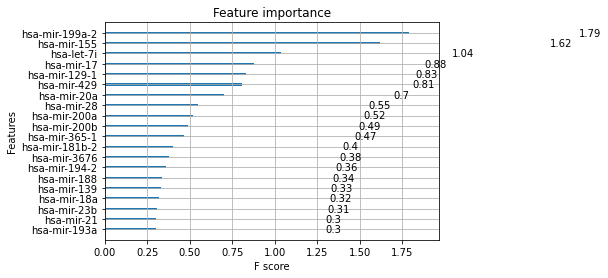

In [22]:

from xgboost import plot_importance

# Get the booster from the xgbmodel
booster = xgb_model_final.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],2)

# provide the importance dictionary to the plotting function
ax = plot_importance(importance, max_num_features=20, importance_type='gain', show_values=True)


In [ ]:
hr_pred_proba = xgb_model_final.predict_proba(input_df_test[input_df.columns[1:]])#,validate_features=True)#, input_df_test[input_df.columns[0]].values-1)


In [77]:
hr_pred_proba = xgb_model_final.predict_proba(input_df_test[input_df.columns[1:]])#,validate_features=True)#, input_df_test[input_df.columns[0]].values-1)


hr_pred_proba.shape

(94, 3)

In [78]:
np.sum(hr_pred_proba[0])

1.0

In [79]:

from sklearn.metrics import roc_auc_score, accuracy_score

In [83]:
accuracy_score(np.argmax(hr_pred_proba,axis=1), input_df_test[input_df.columns[0]])

0.648936170212766

In [84]:
print(classification_report(np.argmax(hr_pred_proba,axis=1), input_df_test[input_df.columns[0]]))


              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.64      0.63      0.64        46
           2       0.50      0.47      0.48        30

    accuracy                           0.65        94
   macro avg       0.67      0.70      0.68        94
weighted avg       0.64      0.65      0.64        94



In [25]:
# print(classification_report(hr_pred_proba.T[188//2:,:], input_df_test[input_df.columns[0]]))

roc_auc_score(
            input_df_test[input_df.columns[0]].values,
            hr_pred_proba[:,:],
#             self.y_pred if len(np.shape(self.y_pred))==1 else self.y_pred[:,1], 
            multi_class='ovo'
        )

0.8686696900982614

In [26]:
roc_auc_score(
            input_df_test[input_df.columns[0]].values,
            hr_pred_proba[:,:],
#             self.y_pred if len(np.shape(self.y_pred))==1 else self.y_pred[:,1], 
            multi_class='ovr'
        )

0.8450807817246173

In [20]:
imp = save_importance_matrix(xgb_model_final)

Creating importance matrix


In [21]:
imp

,gain,cover,weight,total_gain,total_cover
hsa-let-7i,1.040161,16.614639,59.0,61.369476,980.263733
hsa-mir-1-2,0.174002,5.095908,20.0,3.480048,101.918167
hsa-mir-10a,0.258901,5.837817,58.0,15.016255,338.593384
hsa-mir-10b,0.217785,5.103403,18.0,3.920134,91.861244
hsa-mir-1228,0.239293,5.473589,45.0,10.768188,246.311508
hsa-mir-125a,0.212783,5.898917,38.0,8.085759,224.158829
hsa-mir-125b-1,0.221412,5.084087,53.0,11.734852,269.456604
hsa-mir-1277,0.166627,4.382925,31.0,5.165445,135.870667
hsa-mir-129-1,0.833234,7.673101,64.0,53.326962,491.078491
hsa-mir-1307,0.140200,5.436034,58.0,8.131577,315.289978


# Autogluon

In [8]:
# !pip install autogluon

In [61]:
# !pip install mxnet --upgrade

In [23]:
import pandas as pd
from autogluon.tabular import TabularPredictor as task
from sklearn.model_selection import train_test_split
import json

In [10]:
input_df_final = pd.concat([input_df,input_df_val])

In [50]:
time_limit = 180*2
metric = 'roc_auc_ovo_macro' 
save_path = '../final_results/AutoGluon/models/microRNA'  # specifies folder to store trained models
predictor = task(
    label=label, 
    path=save_path, 
    eval_metric=metric).fit(input_df_final, time_limit=time_limit)#,                           
#         hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,)#, presets='best_quality')

Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "../final_results/AutoGluon/models/microRNA/"
AutoGluon Version:  0.3.1
Train Data Rows:    219
Train Data Columns: 47
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [1, 0, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    126128.11 MB
	Train Data (Original)  Memory Usage: 0.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTy

[20:05:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.9112	 = Validation score   (roc_auc_ovo_macro)
	2.17s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ... Training model for up to 347.93s of the 347.93s of remaining time.
	0.9009	 = Validation score   (roc_auc_ovo_macro)
	3.06s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 344.72s of the 344.72s of remaining time.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.8849	 = Validation score   (roc_auc_ovo_macro)
	11.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 359.91s of the 332.75s of remaining time

In [52]:
predictor.evaluate(input_df_test)

Evaluation: roc_auc_ovo_macro on test data: 0.8744520030234316
Evaluations on test data:
{
    "roc_auc_ovo_macro": 0.8744520030234316,
    "accuracy": 0.7021276595744681,
    "balanced_accuracy": 0.7031746031746032,
    "mcc": 0.5228531454003328
}


{'roc_auc_ovo_macro': 0.8744520030234316,
 'accuracy': 0.7021276595744681,
 'balanced_accuracy': 0.7031746031746032,
 'mcc': 0.5228531454003328}

In [56]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.924908,0.343500,13.613422,0.003109,2.861128,2,True,11
1,LightGBM,0.915629,0.005049,3.131966,0.005049,3.131966,1,True,2
2,LightGBMXT,0.915629,0.005092,3.059973,0.005092,3.059973,1,True,1
3,ExtraTreesEntr,0.914957,0.105868,0.623858,0.105868,0.623858,1,True,7
4,RandomForestGini,0.914225,0.105871,0.625833,0.105871,0.625833,1,True,3
5,CatBoost,0.913065,0.004955,0.515225,0.004955,0.515225,1,True,5
6,XGBoost,0.911172,0.007715,2.172333,0.007715,2.172333,1,True,8
7,RandomForestEntr,0.910989,0.105841,0.623105,0.105841,0.623105,1,True,4
8,NeuralNetMXNet,0.900916,0.144591,3.062260,0.144591,3.062260,1,True,9
9,ExtraTreesGini,0.896337,0.105860,0.626754,0.105860,0.626754,1,True,6


In [57]:
# predictor.leaderboard(input_df_test, silent=True)

In [54]:
# pred_probs = predictor.predict_proba(test_data_nolab)
# print("Predictions:  \n", y_pred)
# autogluon_performance = predictor.evaluate_predictions(y_true=y_test, y_pred=pred_probs, auxiliary_metrics=True)

In [58]:
%%time
## Feature importance by autogluon

ag_feature_importance = predictor.feature_importance(input_df_test)
ag_feature_importance.head()

Computing feature importance via permutation shuffling for 47 features using 94 rows with 3 shuffle sets...
	65.82s	= Expected runtime (21.94s per shuffle set)
	2.38s	= Actual runtime (Completed 3 of 3 shuffle sets)


CPU times: user 3.76 s, sys: 332 ms, total: 4.09 s
Wall time: 2.41 s


,importance,stddev,p_value,n,p99_high,p99_low
hsa-mir-199a-2,0.019959,0.003170,0.004152,3,0.038124,0.001794
hsa-mir-129-1,0.014781,0.005329,0.020353,3,0.045320,-0.015757
hsa-mir-23b,0.011949,0.004634,0.023329,3,0.038504,-0.014606
hsa-mir-200b,0.010464,0.005660,0.042622,3,0.042899,-0.021970
hsa-let-7i,0.008749,0.008673,0.111355,3,0.058447,-0.040949


In [60]:
%%time
## Feature importance by autogluon

ag_feature_importance = predictor.feature_importance(input_df_test)
ag_feature_importance.head()

Computing feature importance via permutation shuffling for 47 features using 219 rows with 3 shuffle sets...
	65.89s	= Expected runtime (21.96s per shuffle set)
	2.52s	= Actual runtime (Completed 3 of 3 shuffle sets)


CPU times: user 5.85 s, sys: 280 ms, total: 6.13 s
Wall time: 2.54 s


,importance,stddev,p_value,n,p99_high,p99_low
hsa-mir-199a-2,0.004600,0.000780,0.004726,3,0.009071,0.000130
hsa-mir-200b,0.003270,0.001210,0.021385,3,0.010205,-0.003666
hsa-mir-188,0.002466,0.000602,0.009648,3,0.005915,-0.000984
hsa-let-7i,0.002301,0.000293,0.002682,3,0.003981,0.000622
hsa-mir-129-1,0.002059,0.000912,0.029808,3,0.007285,-0.003167


In [62]:
%%time
## Feature importance by autogluon

ag_feature_importance = predictor.feature_importance(input_df_test)
ag_feature_importance.head()

Computing feature importance via permutation shuffling for 47 features using 94 rows with 3 shuffle sets...
	66.45s	= Expected runtime (22.15s per shuffle set)
	2.38s	= Actual runtime (Completed 3 of 3 shuffle sets)


CPU times: user 3.85 s, sys: 306 ms, total: 4.16 s
Wall time: 2.4 s


,importance,stddev,p_value,n,p99_high,p99_low
hsa-mir-199a-2,0.019959,0.003170,0.004152,3,0.038124,0.001794
hsa-mir-129-1,0.014781,0.005329,0.020353,3,0.045320,-0.015757
hsa-mir-23b,0.011949,0.004634,0.023329,3,0.038504,-0.014606
hsa-mir-200b,0.010464,0.005660,0.042622,3,0.042899,-0.021970
hsa-let-7i,0.008749,0.008673,0.111355,3,0.058447,-0.040949
